--- 
### S-Power 발전출력 예측 모델 
- target 변수 : 발전출력 
- 독립변수 : 대기온도, 대기압, 복수기_진공도, 시간, 주중-주말 여부 
- 데이터 기간 및 수량 : 2021.1/13 ~ 2025.8/29, 총 461건 
--- 

In [116]:
#final data loading 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
import matplotlib.font_manager as fm
plt.rcParams['font.family'] = 'NanumGothic'  
plt.rcParams['axes.unicode_minus'] = False  
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv('df_final.csv')
print(df.shape)
df.head()

(461, 16)


,date_time,대기온도,습도,대기압,열공급량,진공도,열감발량,기준출력,발전출력,송전출력,year,month,day,hour,day_week,주말여부
0,2021-01-13 16:00:00,9.4,0.676,1010.9,337.7,713.0,34.0,746.044597,740.0,729.0,2021,1,13,16,Wednesday,주중
1,2021-01-13 16:08:00,9.2,0.696,1011.0,338.4,713.0,34.0,746.332816,739.0,730.0,2021,1,13,16,Wednesday,주중
2,2021-01-19 09:17:00,-8.2,0.387,1030.5,336.5,722.0,34.0,746.919207,809.0,794.0,2021,1,19,9,Tuesday,주중
3,2021-01-19 09:57:00,-7.4,0.364,1030.9,338.8,720.0,34.0,746.567995,806.0,792.0,2021,1,19,9,Tuesday,주중
4,2021-01-19 11:08:00,-4.9,0.300,1031.5,340.7,720.0,34.0,748.131104,802.0,788.0,2021,1,19,11,Tuesday,주중


In [117]:
# 1. y, train 정의 
y = df['발전출력']
vars = ['대기온도', '대기압', '진공도', 'year', 'month', 'hour', '주말여부']
train = df[vars]
print(train.shape, y.shape)

# 2. 변수 스케일링 
train['주말여부'] = train['주말여부'].map({'주중': 0, '주말': 1})

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler 
scaler = StandardScaler()
num_cols =['대기온도', '대기압', '진공도']
train[num_cols] = scaler.fit_transform(train[num_cols])

train['month_sin'] = np.sin(2 * np.pi * train['month'] / 12)
train['month_cos'] = np.cos(2 * np.pi * train['month'] / 12)
train['hour_sin'] = np.sin(2 * np.pi * train['hour'] / 24)
train['hour_cos'] = np.cos(2 * np.pi * train['hour'] / 24)

print(train.shape, y.shape)

# 3. 검증데이터 분리 
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(train, y, test_size=0.2, random_state=42)

(461, 7) (461,)
(461, 11) (461,)


In [118]:
# 4. baseline model 
from sklearn.ensemble import RandomForestRegressor 
model = RandomForestRegressor(random_state=120)
model.fit(X_train, y_train)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [119]:
# 5. eval 
from sklearn.metrics import root_mean_squared_error, r2_score
model_pred = model.predict(X_valid)
score1 = root_mean_squared_error(y_valid, model_pred)
score2 = r2_score(y_valid, model_pred)

print('RMSE = ', score1)
print('R2 = ', score2)

RMSE =  15.510670149117312
R2 =  0.8218052252997985


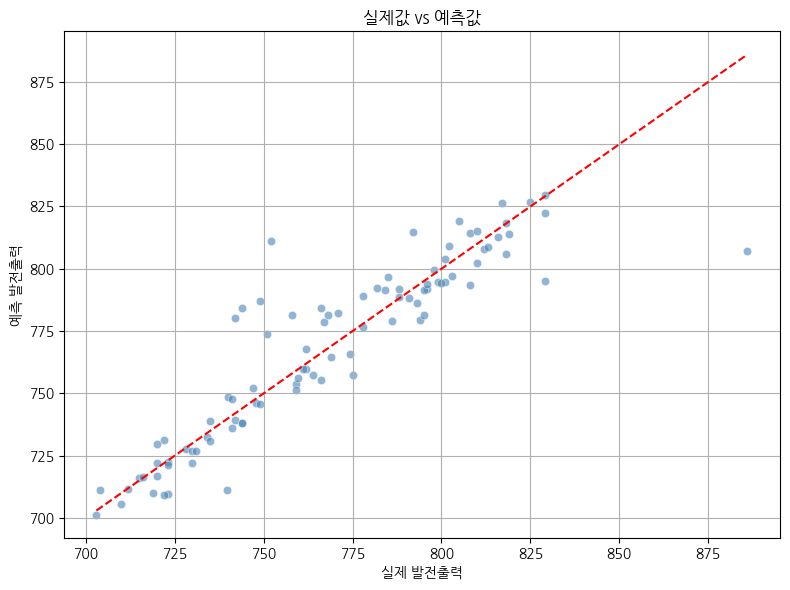

In [120]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_valid, y=model_pred, alpha=0.6, color='steelblue')
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'r--')  # 완벽 예측선
plt.xlabel('실제 발전출력')
plt.ylabel('예측 발전출력')
plt.title('실제값 vs 예측값')
plt.grid(True)
plt.tight_layout()
plt.show()

### Baseline model(RandomForest) 예측성능 
- 발전출력에 대해 약 82.3%의 예측 성능을 나타냄 
- 예측 오차는 약 +/-15.51 수준으로, 측정단위(시간)의 평균 발전출력(772.3 MW) 대비 2% 수준임  

---
## ~ cf. 이하는 advanced model 탐색 과정 
---

Fitting 3 folds for each of 24 candidates, totalling 72 fits
Best Params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200, 'subsample': 0.8}
RMSE = 14.7577
R² = 0.8387


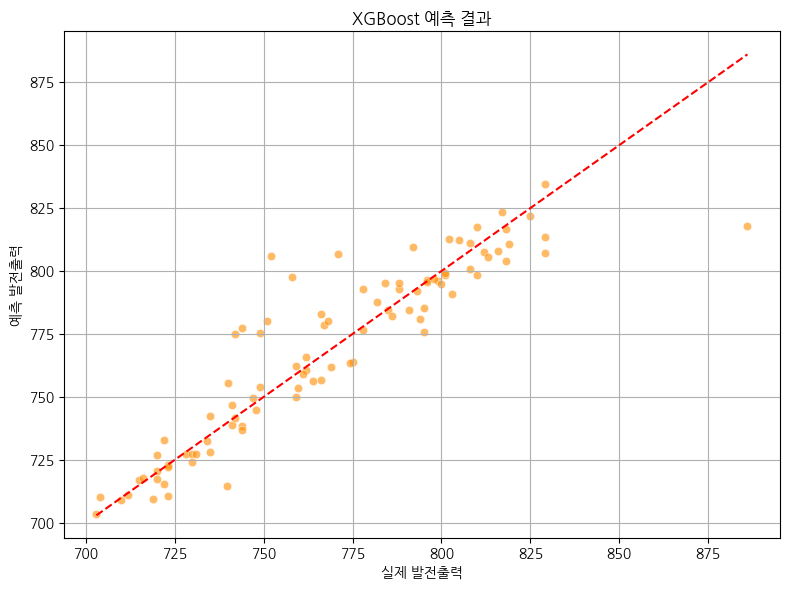

In [126]:
# XGBoost 모델 + GridSearchCV
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.05, 0.1],
    'subsample': [0.8, 1.0]
}

xgb = XGBRegressor(random_state=42, objective='reg:squarederror')
grid_search = GridSearchCV(xgb,
                           param_grid,
                           cv=3,
                           scoring='neg_root_mean_squared_error',
                           n_jobs=-1,
                           verbose=1)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_

# 5. 평가
from sklearn.metrics import mean_squared_error, r2_score

model_pred = best_model.predict(X_valid)
mse = mean_squared_error(y_valid, model_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_valid, model_pred)

print(f'Best Params: {grid_search.best_params_}')
print(f'RMSE = {rmse:.4f}')
print(f'R² = {r2:.4f}')

# 6. 시각화: 실제값 vs 예측값
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_valid, y=model_pred, alpha=0.6, color='darkorange')
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'r--')
plt.xlabel('실제 발전출력')
plt.ylabel('예측 발전출력')
plt.title('XGBoost 예측 결과')
plt.grid(True)
plt.tight_layout()
plt.show()

### XGBoost + Parameters optimizing 예측성능 
- 발전출력에 대해 약 83.9%의 예측 성능을 나타냄 
- 예측 오차는 약 +/-14.7577, 측정단위(시간)의 평균 발전출력(772.3 MW) 대비 1.9% 수준임  

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000562 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 368, number of used features: 10
[LightGBM] [Info] Start training from score 773.306123
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

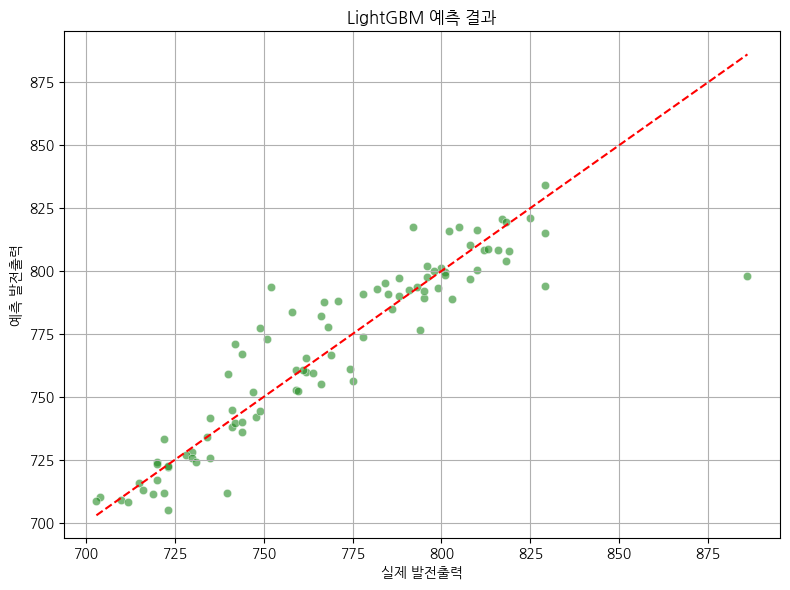

In [ ]:
# LightGBM 모델 + GridSearchCV
from lightgbm import LGBMRegressor

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, -1],
    'learning_rate': [0.05, 0.1],
    'num_leaves': [31, 50],
    'subsample': [0.8, 1.0]
}

lgbm = LGBMRegressor(random_state=42)
grid_search = GridSearchCV(lgbm,
                           param_grid,
                           cv=3,
                           scoring='neg_root_mean_squared_error',
                           n_jobs=-1,
                           verbose=1)

grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_


from sklearn.metrics import mean_squared_error, r2_score
model_pred = best_model.predict(X_valid)
rmse = np.sqrt(mean_squared_error(y_valid, model_pred))
r2 = r2_score(y_valid, model_pred)

print(f'Best Params: {grid_search.best_params_}')
print(f'RMSE = {rmse:.4f}')
print(f'R² = {r2:.4f}')

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_valid, y=model_pred, alpha=0.6, color='forestgreen')
plt.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()], 'r--')
plt.xlabel('실제 발전출력')
plt.ylabel('예측 발전출력')
plt.title('LightGBM 예측 결과')
plt.grid(True)
plt.tight_layout()
plt.show()

### LightGBM + Parameters optimizing 예측성능 
- 발전출력에 대해 약 83.1%의 예측 성능을 나타냄 
- 예측 오차는 약 +/-15.0992, 측정단위(시간)의 평균 발전출력(772.3 MW) 대비 1.96% 수준임  

---
### 최종결과 정리 

| #   | Model                          | R2      | RMSE     | 평균 발전량 대비 예상오차율 |
|-----|--------------------------------|---------|----------|-----------------------------|
| 1   | RandomForest                   | 0.8218  | 15.510   | 2.0%                        |
| 🚩2 | XGBoost + Parameters tune     | 0.8387  | 14.7577  | 1.9%                        |
| 3   | LightGBM + Parameters tune     | 0.8311  | 15.0992  | 1.96%                       |
